# 

# Case Study: Regression

For this chapter, we will use the `tb_diagnosis` dataset seen in
**?@sec-cs-preprocessing** from the **HDSinRdata** package. These data
contains information on 1,762 patients in rural South Africa and urban
Uganda who presented at a health clinic with tuberculosis-related
symptoms and who were tested for tuberculosis (TB) using Xpert MTB/RIF
\[@baik2020clinical\]. Our goal will be to conduct a similar regression
analysis to @baik2020clinical and use these data to derive a risk model
for screening patients for treatment while awaiting Xpert results.
Unlike @baik2020clinical, we will not restrict ourselves to simple
integer risk score models.

In [ ]:
library(tidyverse)
library(HDSinRdata)
library(gt)
library(gtsummary)
library(glmnet)
library(pROC)

Similar to @baik2020clinical, we use the data from rural South Africa to
derive our risk model and will use the data from urban Uganda as a
withheld validation set. Further, we divide the data from South Africa
into a training and test set using a 70/30 split.

In [ ]:
# data from package
data(tb_diagnosis)

# training data
tb_southafrica <- tb_diagnosis %>%
  filter(country == "South Africa") %>%
  select(-country) %>%
  na.omit()

# validation data
tb_uganda <- tb_diagnosis %>%
  filter(country == "Uganda") %>%
  select(-country) %>%
  na.omit()

# train/test split
train_index <- sample(1:nrow(tb_southafrica), 
                      0.70*nrow(tb_southafrica), replace = FALSE)

tb_train <- tb_southafrica[train_index,]
tb_test <- tb_southafrica[-train_index,]

The table below shows our data stratified by TB diagnosis. We observe
that our data are well balanced between the two groups and that we see
key differences in the distributions of our observed clinical and
demographic variables. For example, those whose blood results confirmed
TB generally had more observed symptoms and were more likely to have had
symptoms for over two weeks.

In [ ]:
tbl_summary(tb_southafrica, by = c(tb),
            label = list(age_group ~ "Age",
                          hiv_pos ~ "HIV Positive",
                          diabetes ~ "Diabetes",
                          ever_smoke ~ "Ever Smoked",
                          past_tb ~ "Past TB Diagnosis",
                          male ~ "Male",
                          hs_less ~ "< HS Education",
                          two_weeks_symp ~ "Symptoms for Two Weeks",
                          num_symptoms ~ "Number of TB Symptoms")) %>%
  modify_spanning_header(c("stat_1", "stat_2") ~ 
                           "**TB Diagnosis**") %>%
  as_gt()

## Model Selection

Our goal is to predict TB diagnosis. We will compare two risk models: a
logistic regression model and a lasso logistic regression model. For
both of these models, we will fit our model on the training data. For
the lasso model, we use 5-fold cross-validation to choose the penalty
parameter. We show a table with the estimated exponentiated coefficients
below.

In [ ]:
# fit logistic model 
mod_logistic <- glm(tb ~ ., data = tb_train, family = binomial)

# fit lasso model with CV
X_train <- model.matrix(tb~., data = tb_train)[,-1]
y_train <- tb_train[,1]
mod_lasso_cv <- cv.glmnet(X_train, y_train, alpha = 1, 
                       family = "binomial", nfolds = 5)

# refit for given lambda
mod_lasso <- glmnet(X_train, y_train, alpha = 1, family = "binomial",
                    lambda = mod_lasso_cv$lambda.min)

# create data frame
coef_df <- data.frame(Logistic = signif(exp(coef(mod_logistic)),3),
                      Lasso = 
                        signif(exp(as.numeric(coef(mod_lasso))), 3))
coef_df

                 Logistic  Lasso
(Intercept)        0.0573 0.0988
age_group[15,25)   1.6400 1.2200
age_group[25,35)   2.7700 2.0400
age_group[35,45)   1.9200 1.4800
age_group[45,55)   1.2100 1.0000
hiv_pos1           2.5200 2.3700
diabetes1          1.5200 1.1200
ever_smoke1        0.8570 1.0000
past_tb1           1.2600 1.1300
male1              2.2600 1.9200
hs_less1           1.1100 1.0000
two_weeks_symp1    2.7300 2.5100
num_symptoms2      1.6800 1.4800
num_symptoms3      4.9600 4.2200
num_symptoms4     10.2000 8.1900

We then evaluate our models on the withheld test set using an ROC curve.
The ROC curve shows similar discrimination for both models. Therefore,
we choose the lasso model for its potential sparsity.

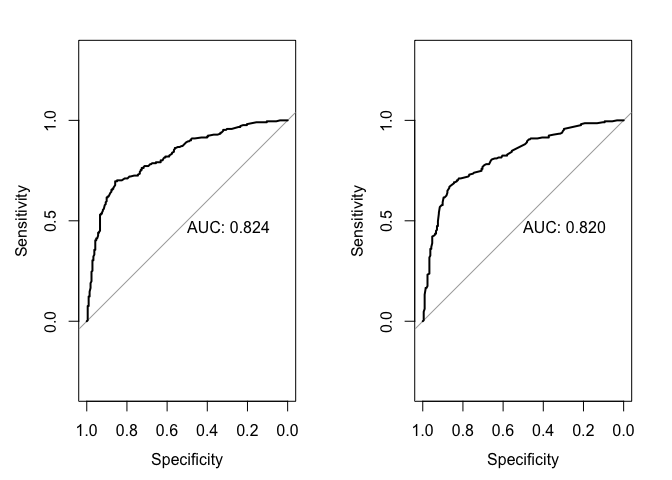

In [ ]:
par(mfrow = c(1,2))

# logistic regression model ROC
pred_test_logistic <- predict(mod_logistic, tb_test, 
                              type = "response")
roc_test_logistic <- roc(predictor = pred_test_logistic,
                     response = tb_test$tb,
                     levels = c(0,1), direction = "<")

plot(roc_test_logistic, print.auc = TRUE)


# lasso model ROC
X_test <- model.matrix(tb~., data = tb_test)[,-1]
pred_test_lasso <- as.numeric(predict(mod_lasso, newx = X_test, 
                                 type = "response"))
roc_test_lasso <- roc(predictor = pred_test_lasso,
                     response = tb_test$tb,
                     levels = c(0,1), direction = "<")

plot(roc_test_lasso, print.auc = TRUE)

We refit the lasso model on the full data from South Africa and present
the updated model below.

In [ ]:
# fit lasso model with CV
X_train_full <- model.matrix(tb~., data = tb_southafrica)[,-1]
y_train_full <- tb_southafrica[,1]
mod_cv_full <- cv.glmnet(X_train_full, y_train_full, alpha = 1, 
                       family = "binomial", nfolds = 5)

# refit for given lambda
mod_full <- glmnet(X_train_full, y_train_full, alpha = 1, 
                   family = "binomial", 
                   lambda = mod_cv_full$lambda.min)

# create data frame
coef_df <- data.frame(
  Variable = c("Intercept", colnames(X_train_full)),
  Lasso = signif(exp(as.numeric(coef(mod_full))),3))
coef_df

           Variable  Lasso
1         Intercept 0.0779
2  age_group[15,25) 1.1000
3  age_group[25,35) 2.0700
4  age_group[35,45) 1.4900
5  age_group[45,55) 1.0200
6          hiv_pos1 2.5400
7         diabetes1 1.6100
8       ever_smoke1 0.8520
9          past_tb1 1.1500
10            male1 2.2700
11         hs_less1 1.1400
12  two_weeks_symp1 2.3900
13    num_symptoms2 1.7600
14    num_symptoms3 5.4500
15    num_symptoms4 9.1300

## Evaluate Model on Validation Data

We then evaluate the lasso model on the withheld validation data. These
data comes from clinics in urban Uganda and contains only 387
observations. The table below shows that this population differs from
our training population including having a lower proportion of patients
diagnosed with TB.

In [ ]:
tbl_summary(tb_diagnosis, by = c(country),
            label = list(tb ~ "TB Diagnosis",
                         age_group ~ "Age",
                         hiv_pos ~ "HIV Positive",
                         diabetes ~ "Diabetes",
                         ever_smoke ~ "Ever Smoked",
                         past_tb ~ "Past TB Diagnosis",
                         male ~ "Male",
                         hs_less ~ "< HS Education",
                         two_weeks_symp ~ "Symptoms for Two Weeks",
                         num_symptoms ~ "Number of TB Symptoms")) %>%
  modify_spanning_header(c("stat_1", "stat_2") ~ "**Country**") %>%
  as_gt()

The ROC curve below shows that the AUC on the validation data is lower
than on the training data but still shows decent discrimination.

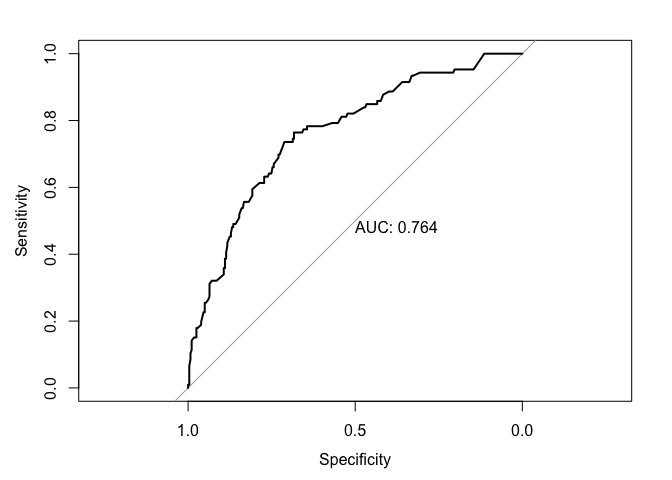

In [ ]:
# lasso validation roc
X_val <- model.matrix(tb~., data = tb_uganda)[,-1]
pred_val <- as.numeric(predict(mod_full, newx = X_val, 
                                      type = "response"))
roc_val_lasso <- roc(predictor = pred_val,
                     response = tb_uganda$tb,
                     levels = c(0,1), direction = "<")

plot(roc_val_lasso, print.auc = TRUE)